<a href="https://colab.research.google.com/github/sandroormeno/El-Martillazo-y-la-danza/blob/master/Estudio_Rt_COVID_19_para_Lima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d


In [0]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])



In [0]:
url = 'https://raw.githubusercontent.com/jmcastagnetto/covid-19-peru-data/master/datos/covid-19-peru-data.csv'
region = pd.read_csv(url,
                     usecols=['date', 'region', 'confirmed'],
                     parse_dates=['date'],
                     index_col=['region', 'date'],
                     squeeze=True).sort_index()

In [9]:
region_name = 'Lima'

provincias = { 'Ancash','Arequipa','Ica','La Libertad','Lambayeque', 'Lima',
              'Loreto', 'Piura','Tumbes','Ucayali'}

def prepare_cases(cases, cutoff=15):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = region.xs(region_name).rename(f"{region_name} cases")

original, smoothed = prepare_cases(cases)

print(region_name)
print(original)


#for i in provincias:
#  cases = states.xs(i).rename(f"{i} cases")
#  original, smoothed = prepare_cases(cases)
#  print(i)
# print(original)


Lima
date
2020-03-15      21.0
2020-03-16      12.0
2020-03-17      26.0
2020-03-18      15.0
2020-03-19      83.0
2020-03-20      18.0
2020-03-21      29.0
2020-03-22      37.0
2020-03-23      29.0
2020-03-24      15.0
2020-03-25      47.0
2020-03-26      84.0
2020-03-27      41.0
2020-03-28      24.0
2020-03-29     121.0
2020-03-30      79.0
2020-03-31      81.0
2020-04-01     191.0
2020-04-02      69.0
2020-04-03     120.0
2020-04-04      78.0
2020-04-05     382.0
2020-04-06     198.0
2020-04-07     263.0
2020-04-08     916.0
2020-04-09     688.0
2020-04-10     506.0
2020-04-11     723.0
2020-04-12     523.0
2020-04-13    2002.0
2020-04-14      18.0
2020-04-15     936.0
2020-04-16     695.0
2020-04-17     686.0
2020-04-18     441.0
2020-04-19     643.0
2020-04-20     420.0
2020-04-21     959.0
2020-04-22     958.0
2020-04-23    1086.0
2020-04-24     514.0
2020-04-25    1753.0
2020-04-26    1317.0
2020-04-27     687.0
2020-04-28    1477.0
2020-04-29    1806.0
2020-04-30    1707.0
202

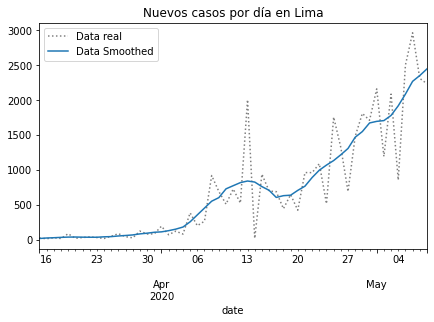

In [15]:
region_name = 'Lima'

def prepare_cases(cases, cutoff=15):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = region.xs(region_name).rename(f"{region_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"Nuevos casos por día en {region_name}",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Data real',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Data Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [0]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

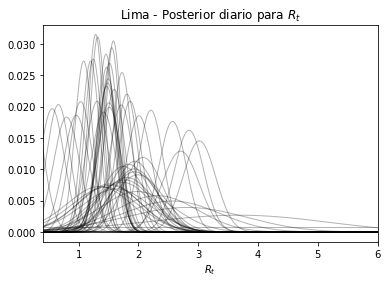

In [17]:
ax = posteriors.plot(title=f'{region_name} - Posterior diario para $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [18]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

#hdis.tail()
result.tail()

,ML,Low_90,High_90
date,,,
2020-05-04,1.46,1.20,1.67
2020-05-05,1.56,1.31,1.76
2020-05-06,1.58,1.36,1.79
2020-05-07,1.32,1.08,1.51
2020-05-08,1.29,1.06,1.48


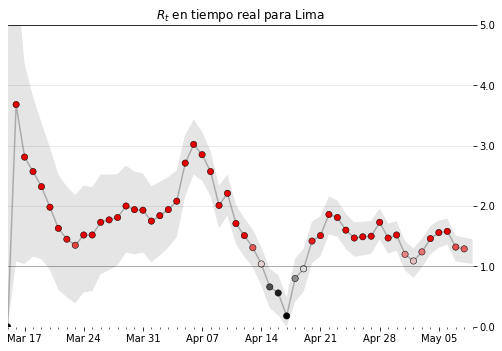

In [19]:
def plot_rt(result, ax, region_name):
    
    ax.set_title(f"{region_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-15'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-15'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, region_name)
ax.set_title(f'$R_t$ en tiempo real para {region_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))